In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, shape
from haversine import haversine, Unit
import pandas as pd
from shapely.geometry import MultiPoint, MultiPolygon
import json
import datetime
from geopy.distance import geodesic
import pyarrow
import json
import matplotlib.pyplot as plt
from utils import *


In [2]:
# full travel dataset
cali_csvs = ['../data/california_jul_nov_2019.csv',
             '../data/california_may_jul_20.csv',
             '../data/california_jul_sep_20.csv',
             '../data/california_sep_nov_20.csv']
data_frames = []
for file in cali_csvs:
    data = pd.read_csv(file, engine='pyarrow')
    data_frames.append(data)
travel_df = pd.concat(data_frames, ignore_index=True).sort_values(by='date')
travel_df['date'] = pd.to_datetime(travel_df.date)

# wildfire dataset
wildfire_df = pd.read_csv('../data/ca_daily_fire_2000_03252022.csv', engine='pyarrow')
wildfire_df['acq_date'] = pd.to_datetime(wildfire_df.acq_date)

In [3]:
# long lats
kincaid_coords = (38.792458, -122.780053)
czu_coords = (37.17162, -122.22275)
august_coords = (39.776, -122.673)

# sq miles affected
kincaid_affected_km = 150
czu_affected_km = 150
august_affected_km = 300

In [4]:
# query on earliest fire (kincaid) to latest fire (august)
wildfire_df = wildfire_df.query('acq_date >= @kincaid_start_date & acq_date <= @august_contained_date')

In [5]:
# process pre fire data
pre_fire_kincaid = process_pre_fire_data(travel_df, kincaid_start_date)
pre_fire_czu = process_pre_fire_data(travel_df, czu_start_date)
pre_fire_august = process_pre_fire_data(travel_df, august_start_date)

# process during fire data
during_fire_kincaid = process_during_fire_data(travel_df, kincaid_start_date, kincaid_contained_date)
during_fire_czu = process_during_fire_data(travel_df, czu_start_date, czu_contained_date)
during_fire_august = process_during_fire_data(travel_df, august_start_date, august_contained_date)

In [6]:
# get distance from county to each wildfire to filter the records
threshold_distance = 10

# kincaid
df_fire_kincaid = wildfire_df.copy()
df_fire_kincaid['dist_to_kincaid'] = df_fire_kincaid.apply(lambda row: geodesic((row['latitude'], row['longitude']), kincaid_coords).kilometers, axis=1)
df_fire_kincaid = df_fire_kincaid[df_fire_kincaid['dist_to_kincaid'] <= threshold_distance]
df_fire_kincaid = df_fire_kincaid.query("acq_date >= '2019-10-23' and acq_date <= '2019-11-06'")

# czu
df_fire_czu = wildfire_df.copy()
df_fire_czu['dist_to_czu'] = df_fire_czu.apply(lambda row: geodesic((row['latitude'], row['longitude']), czu_coords).kilometers, axis=1)
df_fire_czu = df_fire_czu[df_fire_czu['dist_to_czu'] <= threshold_distance]
df_fire_czu = df_fire_czu.query("acq_date >= '2020-08-16' and acq_date <= '2020-09-22'")

# august
df_fire_august = wildfire_df.copy()
df_fire_august['dist_to_august'] = df_fire_august.apply(lambda row: geodesic((row['latitude'], row['longitude']), august_coords).kilometers, axis=1)
df_fire_august = df_fire_august[df_fire_august['dist_to_august'] <= threshold_distance]
df_fire_august = df_fire_august.query("acq_date >= '2020-08-16' and acq_date <= '2020-11-12'")



In [7]:
# get and save blocked pairs
df_travel_kincaid_blocked_pairs = mark_blocked_paths(df_fire_kincaid, during_fire_kincaid, "../data/kincaid_fire_polygons.geojson", buffer_radius_km=2)
df_travel_kincaid_blocked_pairs.to_csv('../data/clean/df_travel_kincaid_blocked_pairs.csv', index=False)

df_travel_czu_blocked_pairs = mark_blocked_paths(df_fire_czu, during_fire_czu, "../data/czu_fire_polygons.geojson", buffer_radius_km=2)
df_travel_czu_blocked_pairs.to_csv('../data/clean/df_travel_czu_blocked_pairs.csv', index=False)

df_travel_august_blocked_pairs = mark_blocked_paths(df_fire_august, during_fire_august, "../data/august_fire_polygons.geojson", buffer_radius_km=2)
df_travel_august_blocked_pairs.to_csv('../data/clean/df_travel_august_blocked_pairs.csv', index=False)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# process geojson
dates_kincaid, areas_kincaid = process_geojson('../data/kincaid_fire_polygons.geojson')
dates_czu, areas_czu = process_geojson('../data/czu_fire_polygons.geojson')
dates_august, areas_august = process_geojson('../data/august_fire_polygons.geojson')

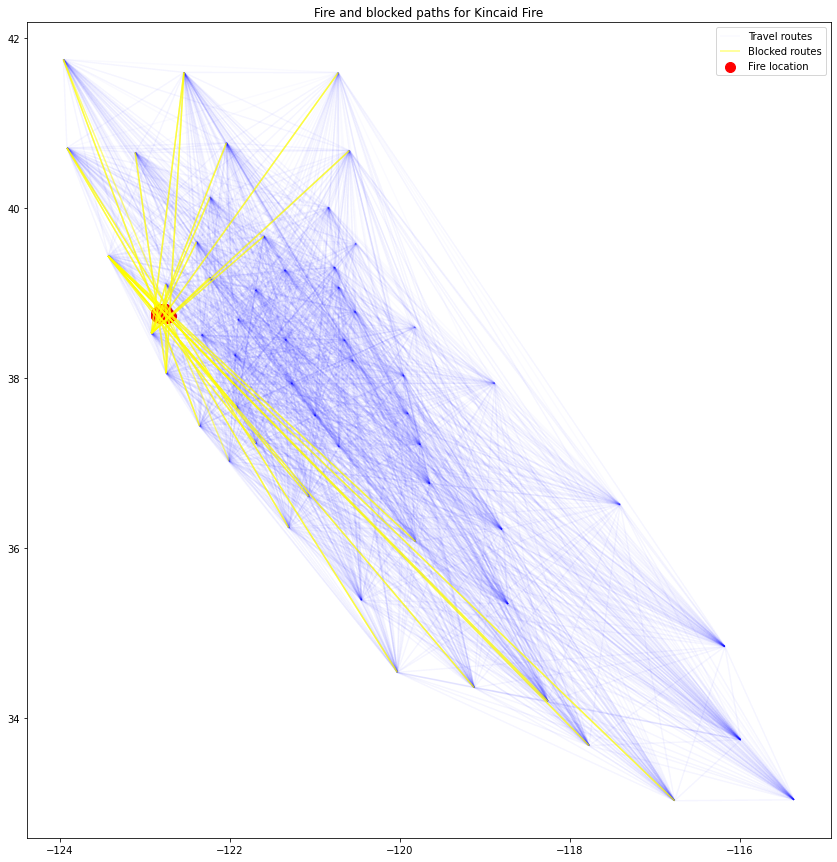

In [9]:
# plot for each fire
plot_data(df_fire_kincaid, during_fire_kincaid, df_travel_kincaid_blocked_pairs, 'Kincaid Fire')

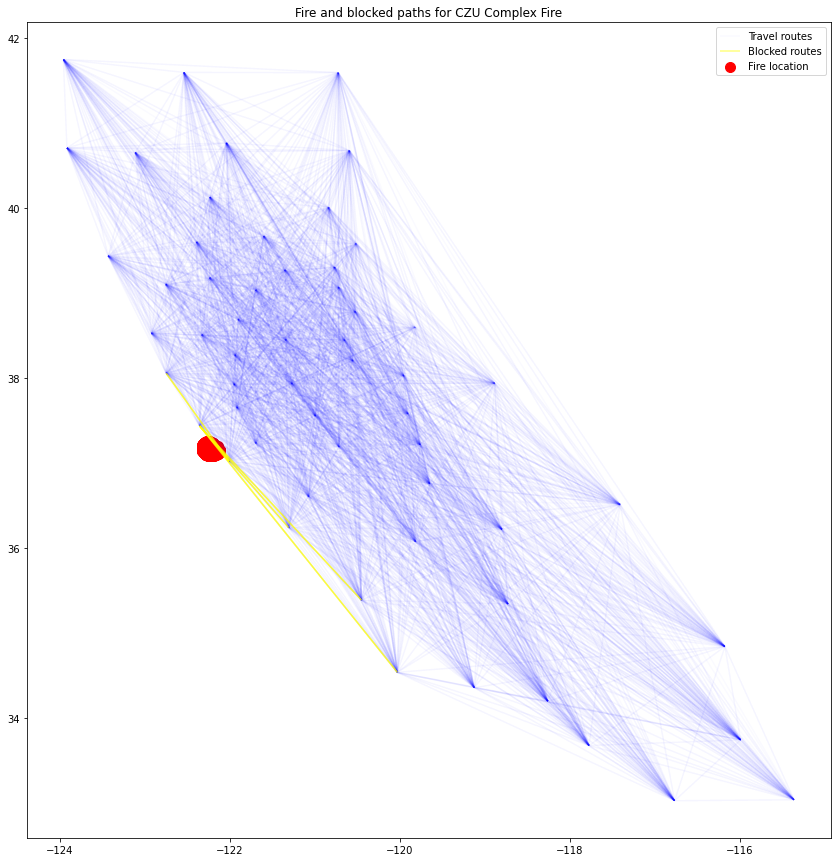

In [10]:
plot_data(df_fire_czu, during_fire_czu, df_travel_czu_blocked_pairs, 'CZU Complex Fire')


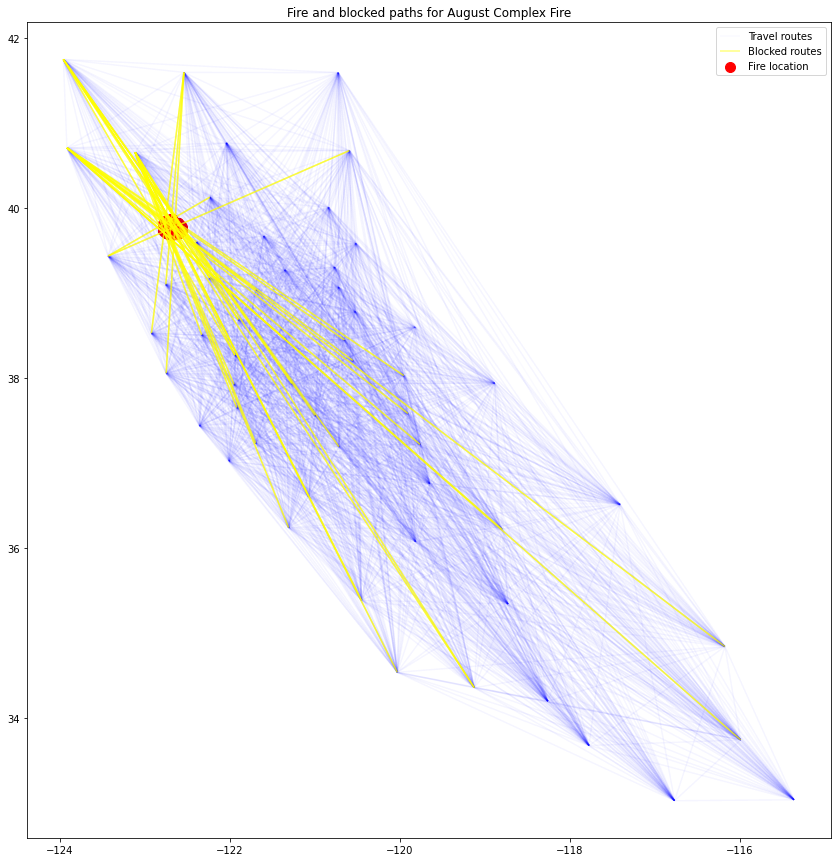

In [11]:
plot_data(df_fire_august, during_fire_august, df_travel_august_blocked_pairs, 'August Complex Fire')


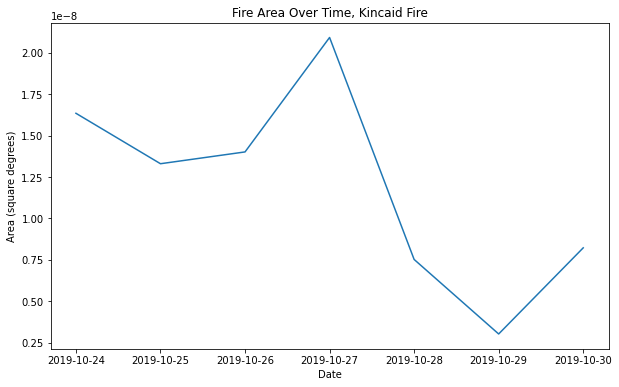

In [12]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates_kincaid, 'Area': areas_kincaid})

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Area'])
plt.xlabel('Date')
plt.ylabel('Area (square degrees)')
plt.title('Fire Area Over Time, Kincaid Fire')
plt.show()

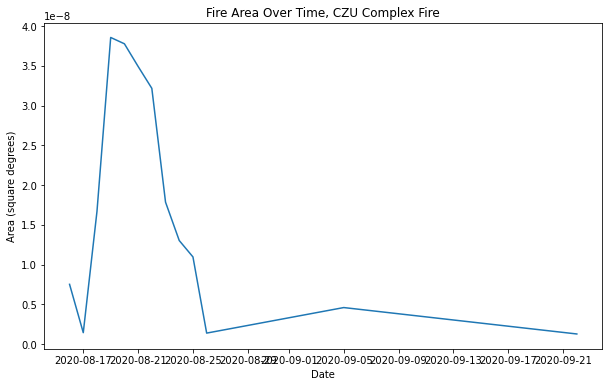

In [13]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates_czu, 'Area': areas_czu})

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Area'])
plt.xlabel('Date')
plt.ylabel('Area (square degrees)')
plt.title('Fire Area Over Time, CZU Complex Fire')
plt.show()

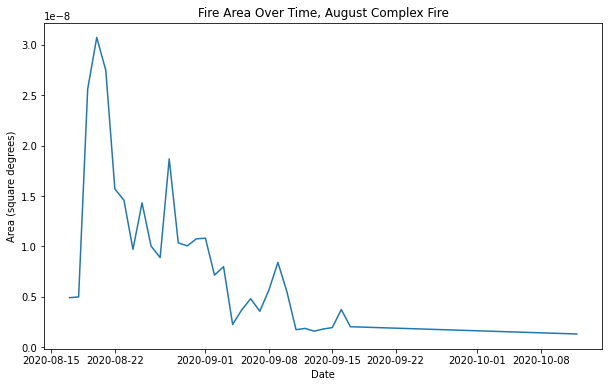

In [14]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates_august, 'Area': areas_august})

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Area'])
plt.xlabel('Date')
plt.ylabel('Area (square degrees)')
plt.title('Fire Area Over Time, August Complex Fire')
plt.show()